# Loads

In [34]:
pip install tqdm

In [35]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile


from PIL import Image
import zipfile

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cpu device


In [37]:
# Clear existing files or directories from previous runs
!rm -f -r "/content/images"
!rm -f "/content/module_metadata.json"

# Define paths for download and extraction
repo_path = "/content/InfraredSolarModules/"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clone the repository and extract the zip file
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $repo_path
!mv "$repo_path/2020-02-14_InfraredSolarModules.zip" $extract_path
!unzip -uq $zip_path -d $extract_path

# Move images folder to the root directory
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# Move module_metadata.json to the root directory
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

# Verify the final structure
!ls /content


fatal: destination path '/content/InfraredSolarModules' already exists and is not an empty directory.
mv: cannot stat '/content/InfraredSolarModules//2020-02-14_InfraredSolarModules.zip': No such file or directory
2020-02-14_InfraredSolarModules.zip  images_b		   module_metadata.json       sample_data
images				     InfraredSolarModules  myModel_best_A_a_9523.pth
images_a			     __MACOSX		   myModel_best_A_b7265.pth


In [38]:
# Path to metadata JSON file
metadata_path = '/content/module_metadata.json'

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Convert metadata to DataFrame
df = pd.DataFrame.from_dict(metadata, orient='index')

# a)

In [ ]:
df_binary = df.copy()
df_binary['anomaly_class'] = df_binary['anomaly_class'].apply(
    lambda x: 1 if x.lower() != 'no-anomaly' else 0
)

# Display DataFrame details
print("*************** Binary Classification DataFrame ***************")
print(df_binary.head())
print("Total rows:", df_binary.shape[0])

train_ratio = 0.8
train_data, test_data = train_test_split(df_binary, test_size=(1-train_ratio), train_size=train_ratio, random_state=11, stratify=df_binary['anomaly_class'])

train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)


*************** Binary Classification DataFrame ***************
         image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
Total rows: 20000


In [ ]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")


In [ ]:
# Transformações
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),   # Random horizontal flip
    transforms.ToTensor(),
])

transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=train_transform)



In [ ]:
train_data_a_counts = train_data['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(train_data_a_counts)
print("Size:", len(train_data), "\n")

# Datasets
train_data_a_balanced = train_data.copy()

directory = "/content/images_a"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data)):
    # Get the row for the current sample
    row = train_data.iloc[i]
    image_path = row["image_filepath"]  # Path to the image
    label = row["anomaly_class"]       # Corresponding label

    # Load the image using PIL
    image_pil = Image.open(image_path).convert("L")

    # Get the ratio for this class

    num1,num2 = random.sample(range(1, 3), 2)
    # Perform deterministic augmentations
    for n in range(2):  # Subtract 1 because the original image already counts as 1
        if(n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        if(n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_a_balanced = pd.concat([train_data_a_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part


train_data_a_balanced_counts = train_data_a_balanced['anomaly_class'].value_counts()
print("\nCounts of each anomaly type:")
print(train_data_a_balanced_counts)
print("Size:", len(train_data_a_balanced))

Counts of each anomaly type:
anomaly_class
1    8000
0    8000
Name: count, dtype: int64
Size: 16000 


Counts of each anomaly type:
anomaly_class
1    24000
0    24000
Name: count, dtype: int64
Size: 48000


In [ ]:
# DataLoaders
train_dataset_a_balanced = MyImageDataset(metadata=train_data_a_balanced, transform=train_transform)
test_dataset = MyImageDataset(metadata=test_data, transform=test_transform)

batch_size = 32
train_loader_a = data.DataLoader(dataset=train_dataset_a_balanced, batch_size=batch_size, shuffle=True)
test_loader_a = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([1, 40, 24])


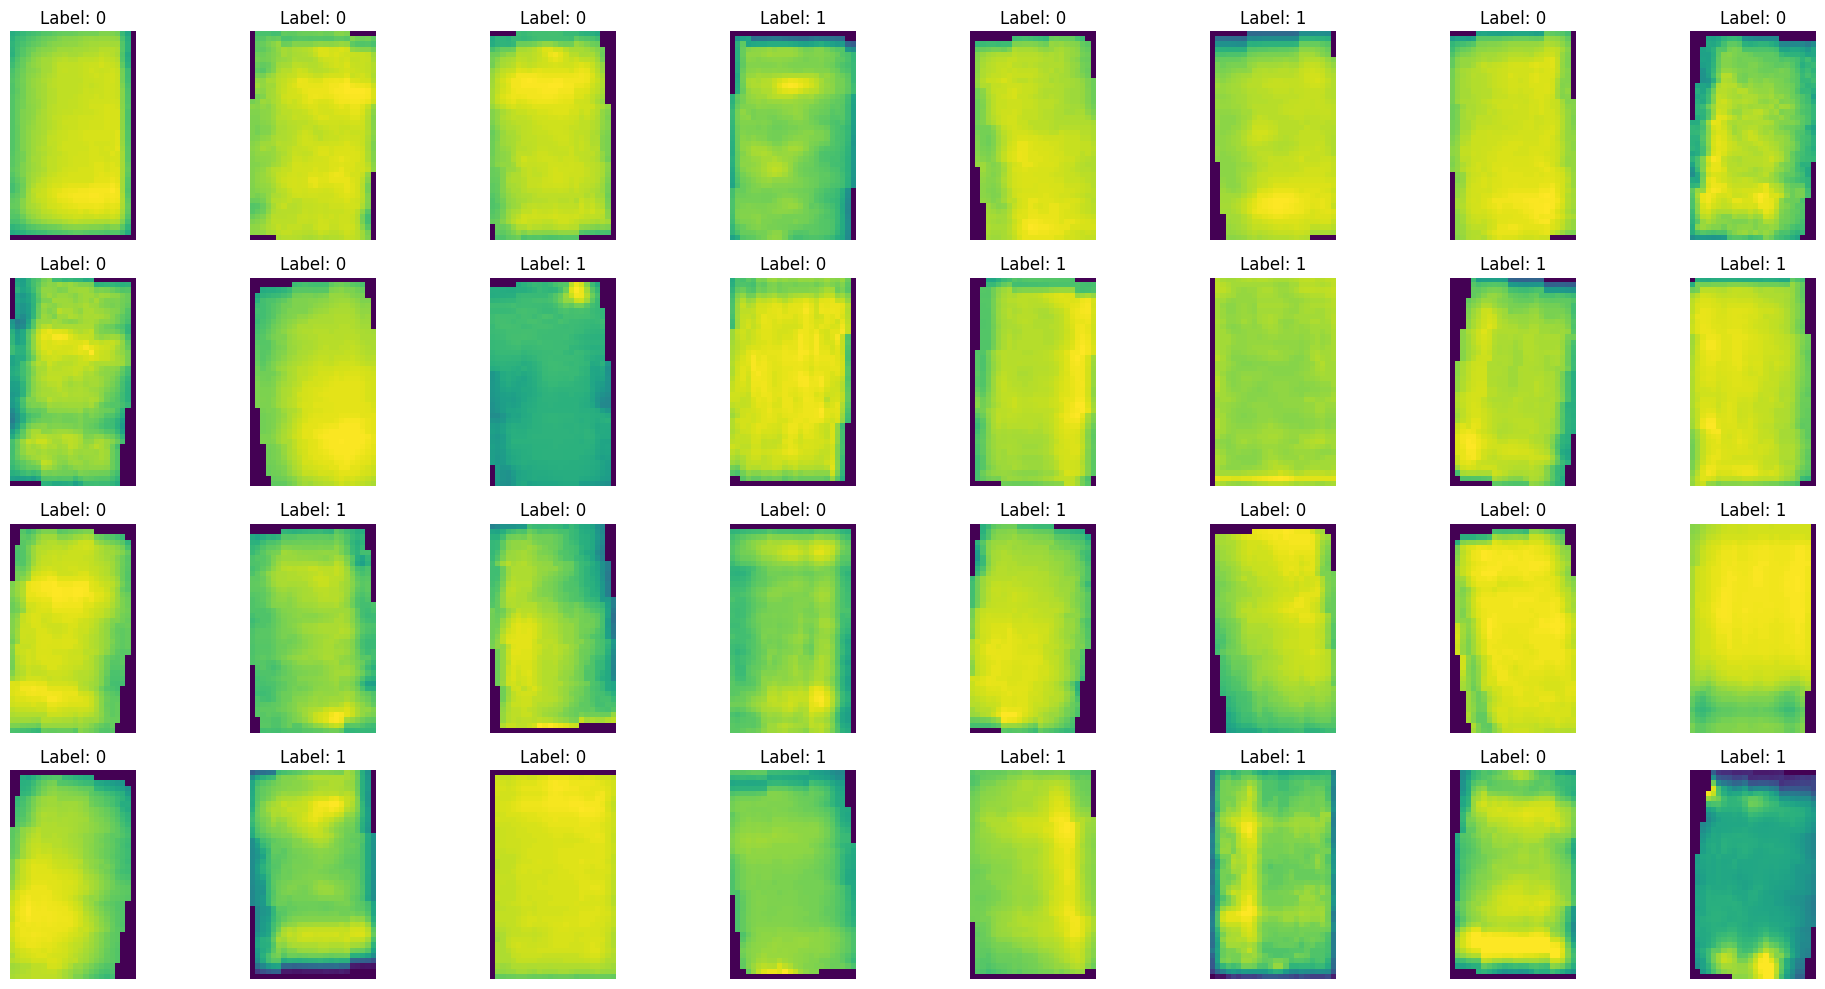

In [ ]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader_a))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)  # Kernel size 5x5
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)  # Kernel size 5x5
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)  # Max pool layer (2x2)

        self.conv3 = nn.Conv2d(256, 512, 3)  # Kernel size 3x3 (adjusted for valid output size)
        self.bn3 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (8, 4)
        # After conv3: (6, 2)

        self.fc1 = nn.Linear(512 * 6 * 2, 1024)  # Increased to 2048 neurons
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)         # Increased to 1024 neurons
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 2)          # Increased to 512 neurons

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)  # Dropout2d after pooling
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = torch.flatten(x, 1)  # Flatten to [batch_size, 256*5*1]

        # Fully connected layers with ReLU and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x


model = Network()
# Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

In [ ]:
# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [ ]:
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc

In [ ]:
if __name__ == "__main__":

    model = model.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model,
                                                    dataloader=train_loader_a,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device,
                                                    num_epochs = 50,
                                                    path_model = str("./myModel_best_A.pth"),
                                                    verbatim = True)

In [ ]:
y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader_a,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

In [ ]:
# Load the model
model = Network()
model = model.to(device)

# Path to the saved model
saved_model_path = "./myModel_best_A_a_9523.pth"

# Load the model's state dictionary
checkpoint = torch.load(saved_model_path, map_location=device)
model.load_state_dict(checkpoint)

# Set model to evaluation mode if you're testing/inferencing
model.eval()

y_pred, test_loss, test_acc  = test(model=model,
                                    dataloader=test_loader_a,
                                    loss_fn=loss_fn,
                                    device=device,
                                    verbatim = True)

<ipython-input-17-021b739a7f66>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path, map_location=device)


Loss = 0.15921416871994734   Accuracy= 0.945


# b)

In [60]:
# Binary Classification DataFrame
df_anomaly = df.copy()

# Filter out the "No-Anomaly" class
df_anomaly = df_anomaly[df_anomaly["anomaly_class"] != "No-Anomaly"]

# Map string labels to numerical labels
df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)

# Print the class distribution
anomaly_counts = df_anomaly['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(anomaly_counts)




Counts of each anomaly type:
anomaly_class
0     1877
8     1639
6     1499
1     1288
5     1056
2      940
10     827
3      249
4      246
9      204
7      175
Name: count, dtype: int64


<ipython-input-60-7568ab101c79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomaly['anomaly_class'] = df_anomaly['anomaly_class'].apply(


In [61]:
train_ratio_b = 0.9
train_data_b, test_data_b = train_test_split(df_anomaly, test_size=(1 - train_ratio_b), train_size=train_ratio_b, random_state=2, stratify=df_anomaly['anomaly_class'])

train_data_b.reset_index(drop=True, inplace=True)
test_data_b.reset_index(drop=True, inplace=True)

In [62]:
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),   # Random horizontal flip
    transforms.ToTensor(),
])

transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [63]:
train_data_b_counts = train_data_b['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(train_data_b_counts)
print("Size:", len(train_data_b), "\n")

# Datasets
train_data_b_balanced = train_data_b.copy()

largest_class_count = train_data_b_counts.max()
ratios = largest_class_count / train_data_b_counts
max_ratio = 4
ratios = np.minimum(ratios, max_ratio)

ratios_sorted = ratios.sort_index()
ratios_matrix=[]

for label, ratio in ratios_sorted.items():
    ratios_matrix.append([label, ratio])
ratios_matrix[0][1]+=0.1
print(ratios_matrix)



directory = "/content/images_b"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data_b)):
    # Get the row for the current sample
    row = train_data_b.iloc[i]
    image_path = row["image_filepath"]  # Path to the image
    label = row["anomaly_class"]       # Corresponding label

    # Load the image using PIL
    image_pil = Image.open(image_path).convert("L")

    # Get the ratio for this class
    ratio = ratios_matrix[int(label)][1]

    # Split the ratio into integer and fractional parts
    int_part = int(ratio)  # Deterministic augmentations
    frac_part = ratio - int_part  # Fractional part for probabilistic augmentation
    num1,num2 = random.sample(range(1, 3), 2)
    # Perform deterministic augmentations
    for n in range(int_part-1):  # Subtract 1 because the original image already counts as 1
        random_number = random.randint(1, 3)
        if(int_part==1):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==0):
            if(num1==1):
                transform_augmentation = transform_augmentation_1
            elif(num1==2):
                transform_augmentation = transform_augmentation_2
            elif(num1==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==2 and n==1):
            if(num2==1):
                transform_augmentation = transform_augmentation_1
            elif(num2==2):
                transform_augmentation = transform_augmentation_2
            elif(num2==3):
                transform_augmentation = transform_augmentation_3
        elif(int_part==3 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==3 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==3 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==0):
            transform_augmentation = transform_augmentation_1
        elif(int_part==4 and n==1):
            transform_augmentation = transform_augmentation_2
        elif(int_part==4 and n==2):
            transform_augmentation = transform_augmentation_3
        elif(int_part==4 and n==3):
            if(random_number==1):
                transform_augmentation = transform_augmentation_1
            elif(random_number==2):
                transform_augmentation = transform_augmentation_2
            elif(random_number==3):
                transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)

    # Perform probabilistic augmentation for the fractional part
    if random.random() < frac_part:  # Augment with probability equal to the fractional part
        random_number = random.randint(1, 3)
        if(random_number==1):
            transform_augmentation = transform_augmentation_1
        elif(random_number==2):
            transform_augmentation = transform_augmentation_2
        elif(random_number==3):
            transform_augmentation = transform_augmentation_3
        transformed_image = transform_augmentation(image_pil)
        x=1
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_2_{int(label)}_{i}_{x}.jpg")
        x+=1
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_b_balanced = pd.concat([train_data_b_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_b_balanced_counts = train_data_b_balanced['anomaly_class'].value_counts()
print("\nCounts of each anomaly type:")
print(train_data_b_balanced_counts)
print("Size:", len(train_data_b_balanced))

Counts of each anomaly type:
anomaly_class
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64
Size: 9000 

[[0, 1.1], [1, 1.4572907679033649], [2, 1.99645390070922], [3, 4.0], [4, 4.0], [5, 1.7778947368421052], [6, 1.252038547071905], [7, 4.0], [8, 1.1450847457627118], [9, 4.0], [10, 2.2701612903225805]]

Counts of each anomaly type:
anomaly_class
0     1863
8     1714
6     1688
2     1683
10    1676
5     1671
1     1665
3      896
4      888
9      736
7      632
Name: count, dtype: int64
Size: 15112


In [64]:
class MyImageDataset_b(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

In [65]:
# DataLoaders
#train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b, transform=train_transform)
train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b_balanced, transform=train_transform)
test_dataset_b = MyImageDataset_b(metadata=test_data_b, transform=test_transform)

batch_size = 32
train_loader_b = data.DataLoader(dataset=train_dataset_b_balanced, batch_size=batch_size, shuffle=True)
test_loader_b = data.DataLoader(dataset=test_dataset_b, batch_size=batch_size, shuffle=False)

tensor(3)
torch.Size([1, 40, 24])


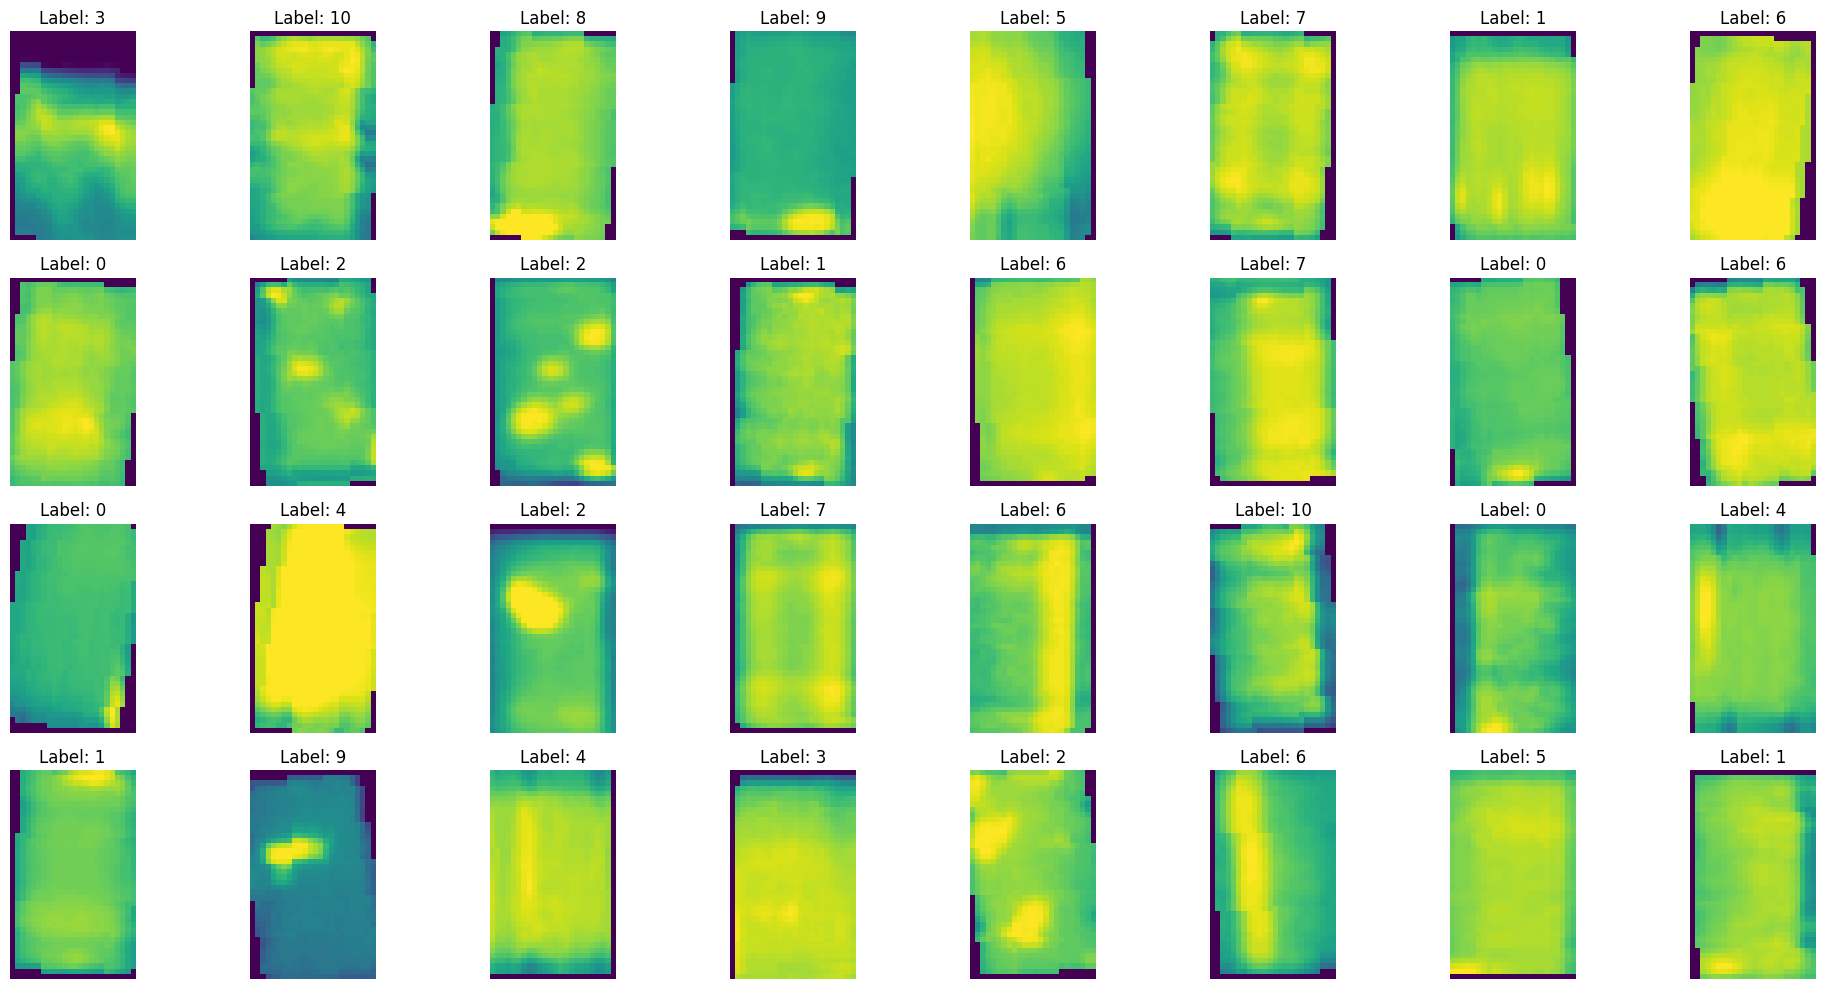

In [66]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images_b, labels_b = next(iter(train_loader_b))  # Pega o primeiro batch
print(labels_b[0])

# Desfazendo a normalização para as imagens
images_b = images_b * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images_b)):
    image = images_b[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_b[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images_b[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()

In [67]:
# Function to save the model
def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = 0.0
    best_epoch = 0
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Adicionando a barra de progresso para os epochs

        train_acc = 0.0
        train_loss = 0.0
        for ibatch, (images, labels) in enumerate(dataloader):  # Adicionando a barra de progresso para os batches

            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # we want to save the model if the accuracy is the best


        if train_acc > best_accuracy:
            path = str(path_model)
            saveModel(model, path = path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            if verbatim:
              print('Best Epoch #', epoch,' Loss=', best_loss, " Accu=", best_accuracy )

    return best_loss, best_accuracy, best_epoch

In [68]:
# Function to test the model with the test dataset and print the accuracy for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim = True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    pred_labels = []
    with torch.no_grad():
        for data in dataloader:

            # get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item()/len(y_pred)
            pred_labels = y_pred_class.tolist()

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    if verbatim:
      print("Loss =", test_loss, "  Accuracy=", test_acc)
    return pred_labels, test_loss, test_acc


In [69]:
class Network_b(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 3)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (16, 8)
        # After conv3: (14, 6)
        # After pool3: (7, 3)
        # After conv4: (5, 1)

        self.fc1 = nn.Linear(512 * 5 * 1, 2048)   # Increase neurons
        self.bn_fc1 = nn.BatchNorm1d(2048)        #  TIR
        self.dropout1 = nn.Dropout(0.4)           # Dropout

        self.fc2 = nn.Linear(2048, 1024)          # Add capacity
        self.bn_fc2 = nn.BatchNorm1d(1024)        # Batch normalization
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)           # Add another layer
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 11)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Optional additional convolutional layer
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.dropout_conv(x)  # Dropout after conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))   # Apply batch normalization after fc1
        x = self.dropout1(x)                 # Apply dropout after activation

        x = F.relu(self.bn_fc2(self.fc2(x)))  # Apply batch normalization after fc2
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))               # Third fully connected layer, no batch norm
        x = self.dropout3(x)                  # Dropout to prevent overfitting

        x = self.fc4(x)

        return x

model_b = Network_b()

class_labels = train_data_b_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#loss_fn_b = nn.CrossEntropyLoss().to(device)
loss_fn_b = nn.CrossEntropyLoss(weight=class_weights).to(device)
#loss_fn_b = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer_b = torch.optim.Adam(model_b.parameters(), lr=0.0001, weight_decay=5e-4)

In [ ]:
if __name__ == "__main__":

    model = model_b.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch = train(model=model_b,
                                                    dataloader=train_loader_b,
                                                    loss_fn=loss_fn_b,
                                                    optimizer=optimizer_b,
                                                    device=device,
                                                    num_epochs = 20,
                                                    path_model = str("./myModel_best_A_b.pth"),
                                                    verbatim = True)

Epochs:   5%|▌         | 1/20 [00:42<13:27, 42.49s/epoch]

New Best Model at Epoch 0: Test Accuracy = 0.3854, Test Loss = 1.7922


Epochs:  10%|█         | 2/20 [01:24<12:39, 42.19s/epoch]

New Best Model at Epoch 1: Test Accuracy = 0.4717, Test Loss = 1.4789


Epochs:  15%|█▌        | 3/20 [02:05<11:50, 41.78s/epoch]

New Best Model at Epoch 2: Test Accuracy = 0.5034, Test Loss = 1.4494


Epochs:  20%|██        | 4/20 [02:48<11:12, 42.04s/epoch]

New Best Model at Epoch 3: Test Accuracy = 0.6005, Test Loss = 1.0887


Epochs:  25%|██▌       | 5/20 [03:30<10:33, 42.22s/epoch]

New Best Model at Epoch 4: Test Accuracy = 0.6092, Test Loss = 1.0437


Epochs:  30%|███       | 6/20 [04:13<09:51, 42.28s/epoch]

New Best Model at Epoch 5: Test Accuracy = 0.6361, Test Loss = 0.9703


Epochs:  40%|████      | 8/20 [05:36<08:24, 42.08s/epoch]

New Best Model at Epoch 7: Test Accuracy = 0.6893, Test Loss = 0.8573


Epochs:  50%|█████     | 10/20 [07:01<07:01, 42.12s/epoch]

New Best Model at Epoch 9: Test Accuracy = 0.7021, Test Loss = 0.7619


Epochs:  55%|█████▌    | 11/20 [07:43<06:18, 42.11s/epoch]

New Best Model at Epoch 10: Test Accuracy = 0.7408, Test Loss = 0.6720


Epochs:  60%|██████    | 12/20 [08:24<05:35, 41.98s/epoch]

New Best Model at Epoch 11: Test Accuracy = 0.7563, Test Loss = 0.6275


Epochs:  65%|██████▌   | 13/20 [09:07<04:55, 42.16s/epoch]

New Best Model at Epoch 12: Test Accuracy = 0.7648, Test Loss = 0.5996


Epochs:  70%|███████   | 14/20 [09:49<04:12, 42.16s/epoch]

New Best Model at Epoch 13: Test Accuracy = 0.7813, Test Loss = 0.5680


Epochs:  75%|███████▌  | 15/20 [10:31<03:30, 42.15s/epoch]

New Best Model at Epoch 14: Test Accuracy = 0.7890, Test Loss = 0.5329


Epochs:  80%|████████  | 16/20 [11:14<02:48, 42.20s/epoch]

New Best Model at Epoch 15: Test Accuracy = 0.7900, Test Loss = 0.5269


Epochs:  85%|████████▌ | 17/20 [11:55<02:05, 41.85s/epoch]

New Best Model at Epoch 16: Test Accuracy = 0.8079, Test Loss = 0.4721


Epochs:  90%|█████████ | 18/20 [12:36<01:23, 41.81s/epoch]

New Best Model at Epoch 17: Test Accuracy = 0.8273, Test Loss = 0.4495


Epochs: 100%|██████████| 20/20 [14:02<00:00, 42.13s/epoch]

New Best Model at Epoch 19: Test Accuracy = 0.8433, Test Loss = 0.3899


In [70]:
model_test_b = Network_b()
model_test_b = model_test_b.to(device)

saved_model_path = "./myModel_best_A_b_7324.pth"
checkpoint = torch.load(saved_model_path, map_location=device)
model_test_b.load_state_dict(checkpoint)
model_test_b.eval()

y_pred, test_loss, test_acc  = test(model=model_test_b,
                                    dataloader=test_loader_b,
                                    loss_fn=loss_fn_b,
                                    device=device,
                                    verbatim = True)

<ipython-input-70-3cbbca01a181>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path, map_location=device)


Loss = 0.9154967227950692   Accuracy= 0.732421875


# c)

In [39]:
# Binary Classification DataFrame
df_all_classes = df.copy()

# Map string labels to numerical labels
df_all_classes['anomaly_class'] = df_all_classes['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)

# Print the class distribution
df_all_classes_count = df_all_classes['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(df_all_classes_count)




Counts of each anomaly type:
anomaly_class
11    10000
0      1877
8      1639
6      1499
1      1288
5      1056
2       940
10      827
3       249
4       246
9       204
7       175
Name: count, dtype: int64


In [40]:
train_ratio_c = 0.9
train_data_c, test_data_c = train_test_split(df_all_classes, test_size=(1 - train_ratio_c), train_size=train_ratio_c, random_state=2, stratify=df_all_classes['anomaly_class'])

train_data_c.reset_index(drop=True, inplace=True)
test_data_c.reset_index(drop=True, inplace=True)

In [41]:
transform_augmentation_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),   # Random horizontal flip
    transforms.ToTensor(),
])

transform_augmentation_2 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
])

transform_augmentation_3 = transforms.Compose([
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    #transforms.RandomCrop((40, 24), padding=1),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Testing transform without augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [42]:
train_data_c_counts = train_data_c['anomaly_class'].value_counts()
print("Counts of each anomaly type:")
print(train_data_c_counts)
print("Size:", len(train_data_c), "\n")

# Datasets
train_data_c_balanced = train_data_c.copy()

largest_class_count = train_data_c_counts.max()
ratios = largest_class_count / train_data_c_counts
max_ratio = 4
ratios = np.minimum(ratios, max_ratio)
ratios_sorted = ratios.sort_index()
ratios_matrix=[]


for label, ratio in ratios_sorted.items():
    ratios_matrix.append([label, ratio])
print(ratios_matrix)



directory = "/content/images_c"
if os.path.exists(directory):
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isdir(file_path):
                shutil.rmtree(file_path)
            else:
                os.remove(file_path)
        except Exception as e:
            print(f"Error deleting file {file_path}: {e}")
else:
    os.makedirs(directory, exist_ok=True)



for i in range(len(train_data_c)):
    # Get the row for the current sample
    row = train_data_c.iloc[i]
    image_path = row["image_filepath"]  # Path to the image
    label = row["anomaly_class"]       # Corresponding label

    # Load the image using PIL
    image_pil = Image.open(image_path).convert("L")

    # Get the ratio for this class
    ratio = ratios_matrix[int(label)][1]

    # Split the ratio into integer and fractional parts
    int_part = int(ratio)  # Deterministic augmentations
    frac_part = ratio - int_part  # Fractional part for probabilistic augmentation
    num1,num2 = random.sample(range(1, 3), 2)
    # Perform deterministic augmentations
    for n in range(int_part-1):  # Subtract 1 because the original image already counts as 1
        if(n==0):
            transform_augmentation = transform_augmentation_1
        elif(n==1):
            transform_augmentation = transform_augmentation_2
        elif(n==2):
            transform_augmentation = transform_augmentation_3

        transformed_image = transform_augmentation(image_pil)
        if isinstance(transformed_image, torch.Tensor):
            transformed_image = transforms.ToPILImage()(transformed_image)
        new_image_path = os.path.join(directory, f"transformed_image_{int(label)}_{i}_{n}.jpg")
        transformed_image.save(new_image_path, format="JPEG", quality=95)
        new_row = {"image_filepath": new_image_path, "anomaly_class": int(label)}
        train_data_c_balanced = pd.concat([train_data_c_balanced, pd.DataFrame([new_row])], ignore_index=True)


train_data_c_balanced_counts = train_data_c_balanced['anomaly_class'].value_counts()
print("\nCounts of each anomaly type:")
print(train_data_c_balanced_counts)
print("Size:", len(train_data_c_balanced))

Counts of each anomaly type:
anomaly_class
11    9000
0     1689
8     1475
6     1349
1     1159
5      950
2      846
10     744
3      224
4      222
9      184
7      158
Name: count, dtype: int64
Size: 18000 

[[0, 4.0], [1, 4.0], [2, 4.0], [3, 4.0], [4, 4.0], [5, 4.0], [6, 4.0], [7, 4.0], [8, 4.0], [9, 4.0], [10, 4.0], [11, 1.0]]

Counts of each anomaly type:
anomaly_class
11    9000
0     6756
8     5900
6     5396
1     4636
5     3800
2     3384
10    2976
3      896
4      888
9      736
7      632
Name: count, dtype: int64
Size: 45000


In [43]:
class MyImageDataset_c(data.Dataset):
    def __init__(self, metadata, transform=None, img_mode="L"):

        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform
        self.img_mode = img_mode

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):

        try:
            img_path = self.img_paths[idx]

            # Ensure the image file exists
            if not os.path.exists(img_path):
                raise FileNotFoundError(f"Image file not found: {img_path}")

            # Open and convert the image
            image = Image.open(img_path).convert(self.img_mode)
            label = self.img_labels[idx]

            # Apply transformations if specified
            if self.transform:
                image = self.transform(image)

            return image, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            raise RuntimeError(f"Error loading sample at index {idx}: {e}")

In [44]:
# DataLoaders
#train_dataset_b_balanced = MyImageDataset_b(metadata=train_data_b, transform=train_transform)
train_dataset_c_balanced = MyImageDataset_c(metadata=train_data_c_balanced, transform=train_transform)
test_dataset_c = MyImageDataset_c(metadata=test_data_c, transform=test_transform)

batch_size = 32
train_loader_c = data.DataLoader(dataset=train_dataset_c_balanced, batch_size=batch_size, shuffle=True)
test_loader_c = data.DataLoader(dataset=test_dataset_c, batch_size=batch_size, shuffle=False)

tensor(11)
torch.Size([1, 40, 24])


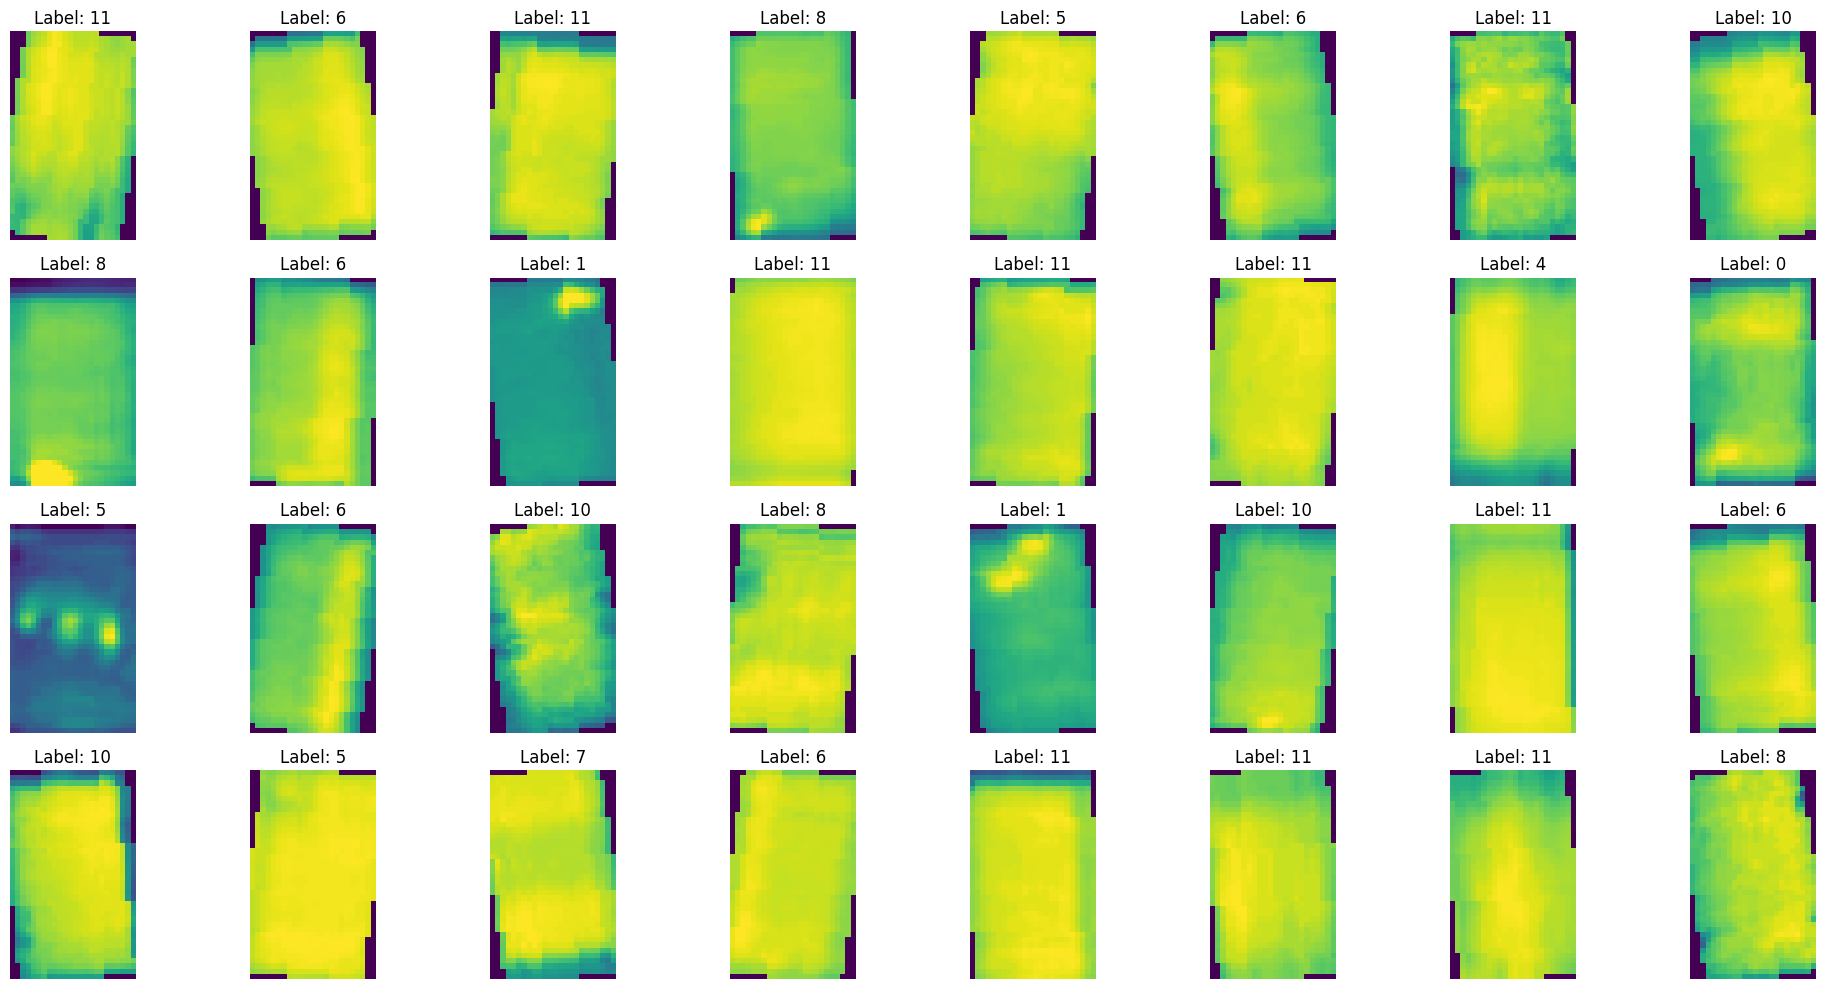

In [45]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images_c, labels_c = next(iter(train_loader_c))  # Pega o primeiro batch
print(labels_c[0])

# Desfazendo a normalização para as imagens
images_c = images_c * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images_c)):
    image = images_c[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels_c[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

print(images_c[0].shape)
plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()

In [46]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def saveModel(model:nn.Module, path):
    torch.save(model.state_dict(), path)

def train(model: torch.nn.Module,
          dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler,
          device: torch.device,
          num_epochs,
          path_model,
          verbatim):
    model.train()
    model.to(device)
    best_accuracy = 0.0
    best_loss = float('inf')  # Initialize with a large value
    best_epoch = 0
    best_f1 = 0.0  # To keep track of the best F1-score

    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):  # Progress bar for epochs

        train_acc = 0.0
        train_loss = 0.0
        all_preds = []
        all_labels = []

        for ibatch, (images, labels) in enumerate(dataloader):  # Progress bar for batches

            # Get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # 1. Forward pass
            y_pred = model(images)
            y_pred = y_pred.squeeze(dim=1)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            train_loss += loss.item()

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

            # Calculate and accumulate accuracy metric across all batches
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            train_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            # Collect predictions and labels for F1-score calculation
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Adjust metrics to get average loss and accuracy per batch
        train_loss = train_loss / len(dataloader)
        train_acc = train_acc / len(dataloader)

        # Calculate F1-score for the epoch
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted")  # "weighted" accounts for class imbalance

        # Save the model if accuracy or F1-score is the best
        if train_loss < best_loss or epoch_f1 > best_f1:
            path = str(path_model)
            saveModel(model, path=path)
            best_loss = train_loss
            best_accuracy = train_acc
            best_epoch = epoch
            best_f1 = epoch_f1

        # Step the scheduler
        scheduler.step(train_loss)  # Pass in train_loss to monitor for plateau

        if verbatim:
            print(f'Epoch #{epoch}: Loss={train_loss:.4f}, F1-score={epoch_f1:.4f}, Accuracy={train_acc:.4f}')

    return best_loss, best_accuracy, best_epoch, best_f1


In [47]:
from sklearn.metrics import f1_score

# Function to test the model with the test dataset and print the accuracy and F1-score for the test images
def test(model: torch.nn.Module,
         dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         device: torch.device,
         verbatim=True):

    # Put model in eval mode
    model.eval()
    model.to(device)
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            # Get the inputs
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # 1. Run the model on the test set to predict labels
            y_pred = model(images)

            # 2. Calculate and accumulate loss
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item()

            # 3. Calculate and accumulate accuracy
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == labels).sum().item() / len(y_pred)

            # Collect predictions and true labels for F1-score calculation
            all_preds.extend(y_pred_class.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    # Calculate F1-score
    test_f1 = f1_score(all_labels, all_preds, average="weighted")

    if verbatim:
        print(f"Loss = {test_loss:.4f}, F1-score = {test_f1:.4f}, Accuracy = {test_acc:.4f}")

    return all_preds, test_loss, test_acc, test_f1


In [51]:
class Network_c(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional and pooling layers with kernel size 5x5 for the first two layers, 3x3 for the third layer
        self.conv1 = nn.Conv2d(1, 128, 3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(128, 256, 3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 1)

        self.conv3 = nn.Conv2d(256, 512, 3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(512, 512, 3)  # Extra layer
        self.bn4 = nn.BatchNorm2d(512)

        self.dropout_conv = nn.Dropout2d(0.2)

        # Calculating the correct input size for the fully connected layer
        # Initial    : (40, 24)
        # After conv1: (38, 22)
        # After pool1: (19, 11)
        # After conv2: (17, 9)
        # After pool2: (16, 8)
        # After conv3: (14, 6)
        # After pool3: (7, 3)
        # After conv4: (5, 1)

        self.fc1 = nn.Linear(512 * 5 * 1, 2048)   # Increase neurons
        self.bn_fc1 = nn.BatchNorm1d(2048)        #  TIR
        self.dropout1 = nn.Dropout(0.4)           # Dropout

        self.fc2 = nn.Linear(2048, 1024)          # Add capacity
        self.bn_fc2 = nn.BatchNorm1d(1024)        # Batch normalization
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(1024, 256)           # Add another layer
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 12)

    def forward(self, x):
        # First convolutional layer, ReLU, and pooling
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Optional additional convolutional layer
        x = F.relu(self.bn4(self.conv4(x)))

        x = self.dropout_conv(x)  # Dropout after conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))   # Apply batch normalization after fc1
        x = self.dropout1(x)                 # Apply dropout after activation

        x = F.relu(self.bn_fc2(self.fc2(x)))  # Apply batch normalization after fc2
        x = self.dropout2(x)

        x = F.relu(self.fc3(x))               # Third fully connected layer, no batch norm
        x = self.dropout3(x)                  # Dropout to prevent overfitting

        x = self.fc4(x)

        return x

model_c = Network_c()

class_labels = train_data_c_balanced['anomaly_class'].values
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_labels), y=class_labels)
class_weights /= class_weights.sum()
print(class_weights)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#loss_fn_b = nn.CrossEntropyLoss().to(device)
loss_fn_c = nn.CrossEntropyLoss(weight=class_weights).to(device)
#loss_fn_b = nn.CrossEntropyLoss().to(device)

# Define the optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0025, momentum=0.9, weight_decay=1e-4)
optimizer_c = torch.optim.Adam(model_c.parameters(), lr=0.0001, weight_decay=5e-4)
scheduler_c = ReduceLROnPlateau(optimizer_c, mode='min', factor=0.1, patience=5, verbose=True)

[0.02142837 0.03122737 0.04278076 0.16157376 0.16302938 0.03809739
 0.02682915 0.2290666  0.0245373  0.19669849 0.04864586 0.01608557]


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
if __name__ == "__main__":

    model = model_c.to(device)

    # Build our model
    best_loss, best_accuracy, best_epoch, best_f1 = train(model=model_c,
                                                          dataloader=train_loader_c,
                                                          loss_fn=loss_fn_c,
                                                          optimizer=optimizer_c,
                                                          scheduler=scheduler_c,
                                                          device=device,
                                                          num_epochs = 30,
                                                          path_model = str("./myModel_best_A_c_78.pth"),
                                                          verbatim = True)

In [53]:
model_test_c = Network_c()
model_test_c = model_test_c.to(device)

saved_model_path = "./myModel_best_A_c_81.pth"
checkpoint = torch.load(saved_model_path, map_location=device)
model_test_c.load_state_dict(checkpoint)
model_test_c.eval()

all_preds, test_loss, test_acc, test_f1  = test(model=model_test_c,
                                                dataloader=test_loader_c,
                                                loss_fn=loss_fn_c,
                                                device=device,
                                                verbatim = True)

<ipython-input-53-e202259f3ab7>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_model_path, map_location=device)


KeyboardInterrupt: 